In [3]:
struct Global
    nv          ::Int    #boundary point
    jx          ::Int    #cell number
    #nm          ::Int    #N of matter
    kindProblem ::Int #kind of problem
    tt          ::Float64      #total time
    cfl         ::Float64     # cfl
end

struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end
    

struct Var
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end


$$ 1Pa = 1N/m^2 = 1 kg/(m\cdot s^2) = 10^{-11} g/(cm \cdot \mu s^2)$$ 

$$ 1 m/s = 10^{-4} cm/\mu s$$
$$ 1kg/m^3 = 10^{-3} g/cm^3$$


$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [4]:

function fη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end


fηη (generic function with 1 method)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [5]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

$$ \begin{aligned}
    & \rho = uo[1]\\
    & u  = uo[2]\\
    & p =uo[3]\\
    & s_{xx}=uo[4]
     \end{aligned} \hspace{0.3cm}
    \begin{aligned}
    &U[1]=\rho\\
    &U[2]=\rho u\\
    &U[3]=\rho E\\
    &U[4]=s_{xx}\\
    \end{aligned}
$$

$$ e=E/\rho-\frac{1}{2}u^2$$


In [6]:
"""
 from  the primitive variables uo to  conservative variables U
"""
function UoTou(uo::Array{Float64,1},con::Const)
    u = zeros(Float64, 4)
    u[1]=uo[1]
    u[2]=uo[2]*uo[1]
    ei = PToe(uo[1],uo[3],con)
    u[3]=(ei+0.5uo[2]^2)*uo[1]
    u[4]=uo[4]
    return u
end

UoTou

In [7]:
"""
 from conservative variables U  to  the primitive variables uo
"""
function UToUo(u::Array{Float64,1},con::Const)
    uo = zeros(Float64, 4)
    uo[1]=u[1]
    uo[2]=u[2]/u[1]
    ei=u[3]/uo[1]-0.5uo[2]^2
    p = EToP(uo[1],ei,con)
    uo[3]=p
    uo[4]=u[4]
    return uo
end  

UToUo

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

In [8]:
function sound(uo::Array{Float64,1},con::Const)
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
  #  c = ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,fηη(ρ,con),p)
    
    c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
    
    return c
end




sound (generic function with 1 method)

In [9]:
# ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,f,p)=try
#         sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
#     catch
#         println("a2= ",a2,"ρ0 = ", ρ0,"ρ = ",
#             ρ, "Γ0= ",Γ0,"Sxx = ", sxx,μ, "a0 = ", 
#             a0, "f = ",f, "p = ", p)
#     end



In [10]:
function Cfl(uo::Array{Float64,2},x::Array{Float64,1},
        inter::Array{Int,1},problem::Global=problem )
    nv=problem.nv
    jx=problem.jx
    sf=problem.cfl
    
   dx1=0
   dxmin=x[nv+2]-x[nv+1]
    for i in nv+2:jx+nv+1
        dx  = x[i]-x[i-1]
        if inter[i] == 1
            c = sound(uo[i,:],con1)
        else
            c = sound(uo[i,:],con2)
        end
        dxmin = min(dx,dxmin)
        dx1=dxmin/c
    end
   dt=sf*dx1
   return dt
end    

Cfl (generic function with 2 methods)

In [11]:
function WENO3(u::Array{Float64,1})
    ε = 1.e-4
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        IS0 = (u[i] - u[i-1])^2
        IS1 = (u[i+1] - u[i])^2
        
        c0 = 2/3
        c1 = 1/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
     #   β0 = c0
     #   β1 = c1
        
        uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
        
        c0 = 1/3
        c1 = 2/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
     #   β0 = c0
     #   β1 = c1
        uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
    end
    return uL,uR
end

function WENO3_new(u::Array{Float64,1})
    ε = 1.e-6
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-2
        q0 = u[i] - u[i-1]
        q1 = u[i+1] - u[i]
 
        β0 = (abs(q0+q1)-abs(3q0-q1))^2+ε 
        β1 = (abs(q0+q1)-abs(3q1-q0))^2+ε
        
         w = 1.0/(1.0+2.0(β0/β1))
        uL[i] = u[i] + (w*(q0-q1)+ q1)/2
        
        q0 = u[i+1] - u[i+2]
        q1 = -q1
        
        β0 = (abs(q0+q1)-abs(3q0-q1))^2+ε 
        β1 = (abs(q0+q1)-abs(3q1-q0))^2+ε
        
        uR[i] = u[i+1] + (w*(q0-q1)+ q1)/2
    end
    return uL,uR
end


function WENO3(u::Array{Float64,1},inter::Array{Int,1},ik::Int)
    
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    
    for i in 2:I-1
        
        if inter[i] != inter[i+1] #&& (ik == 4 || ik == 3) 
                
            IS0 = (u[i] - u[i-1])^2
            IS1 = 0  #(u[i+1] - u[i])^2

            c0 = 2/3
            c1 = 1/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uR[i-1] = β0*(u[i]+u[i-1])/2+β1*u[i]
             uR[i-1] = u[i]

            c0 = 1/3
            c1 = 2/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uL[i] = β0*(3u[i]-u[i-1])/2+β1*u[i]
               uL[i] = u[i]
        elseif inter[i] != inter[i-1] #&& (ik == 4 || ik ==3)
            IS0 = 0 # (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
        
            c0 = 2/3
            c1 = 1/3
        
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*u[i]+β1*(3u[i]-u[i+1])/2
            
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*u[i]+β1*(u[i]+u[i+1])/2
          ##  uR[i-1] = u[i]
          #  uL[i] =u[i]
         else
            IS0 = (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
            
            c0 = 2/3
            c1 = 1/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
            
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
        end
    end
    return uL,uR
end

WENO3 (generic function with 2 methods)

In [12]:
function Upwind(u::Array{Float64,1})
     I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        uL[i] = u[i]
        uR[i] = u[i+1]
    end
    return uL,uR
end


Upwind (generic function with 1 method)

In [13]:
function Yυ(s::Float64,con::Const=con)
    Y0 = con.Y0
    f=0
    if abs(s) <= 2Y0/3
        f = s
    elseif s > 2Y0/3
        f = 2Y0/3
    else
        f = -2Y0/3
    end
end

Yυ (generic function with 2 methods)

$$s^* = \frac{\sigma_L -\sigma_R+\rho_L u_L(s_L-u_L)}$$

In [14]:
function HLLCEPNew1(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    ue = zeros(Float64,J)
    
    for  i in 1:I
           if inter[i] == 1 
            conL = con1
            conR = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ

            Y0R = con1.Y0
            ρ0R = con1.ρ0
            Γ0R = con1.Γ0
            a0R = con1.a0
            μR  = con1.μ
        else
            conL = con2
            conR = con2
            Y0L = con2.Y0
            ρ0L = con2.ρ0
            Γ0L = con2.Γ0
            a0L = con2.a0
            μL  = con2.μ

            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ
            
            conR = con2
            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4.0μL/3*log(ρLstar/ρL) +sxxL
        if (abs(sxxL) < 2Y0L/3 && abs(tmp) >= 2Y0L/3)

       # if abs(tmp) >= 2Y0/3 
            if tmp > 2Y0L/3
                hsxxL = 2Y0L/3
                hρL  = ρL*exp(-Y0L/(2μL)+3sxxL/(4μL))
            elseif tmp < -2/3*Y0L
                hsxxL = -2Y0L/3
                hρL  = ρL*exp(Y0L/(2μL)+3sxxL/(4μL))
            end
            t    = 1/ρL-1/hρL
            c0   = 1/(ρ0L*Γ0L)
            c1   = a0L^2/Γ0L
            hpL   = (2(c1*fη(hρL,conL)+eL)-t*(σL+hsxxL))/(2c0-t)
            hσL = -hpL + hsxxL
            if ρLstar > ρL
               huuL = uuL -sqrt((σL-hσL)*t)
            else
               huuL = uuL +sqrt((σL-hσL)*t)
            end
            ρL   = hρL
            uuL  = huuL
            pL   = hpL
            sxxL = hsxxL
            σL   = hσL
            ue[1] = ρL
            ue[2] = uuL
            ue[3] = pL
            ue[4] = sxxL
            cL = sound(ue,conL)
        end
        
        tmp = -4.0μR/3*log(ρRstar/ρR) +sxxR
        if abs(sxxR) < 2Y0R/3 && abs(tmp) >= 2Y0R/3 
        #if abs(tmp) >= 2Y0/3
            if tmp > 2Y0R/3
               hsxxR = 2Y0R/3
               hρR  = ρR*exp(-Y0R/(2μR)+3sxxR/(4μR))
            elseif tmp < -2/3*Y0R
               hsxxR = -2Y0R/3
               hρR  = ρR*exp(Y0R/(2μR)+3sxxR/(4μR))
            end
            t    = 1/ρR-1/hρR
            c0   = 1/(ρ0R*Γ0R)
            c1   = a0R^2/Γ0R
           hpR   = (2(c1*fη(hρR,conR)+eR)-t*(σR+hsxxR))/(2c0-t)
           hσR = -hpR +hsxxR
            if ρRstar > ρR
               huuR = uuR +sqrt((σR-hσR)*t)
            else
               huuR = uuR -sqrt((σR-hσR)*t)
            end
            ρR = hρR
            uuR = huuR
            pR = hpR
            sxxR = hsxxR
            σR = hσR
            ue[1] = ρR
            ue[2] = uuR
            ue[3] = pR
            ue[4] = sxxR
            cR = sound(ue,conR)
        end
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        if tmp >= 2Y0L/3
            sxxLstar = 2Y0L/3
        elseif tmp <= -2Y0L/3
            sxxLstar  = -2Y0L/3
        else
            sxxLstar = tmp
        end
        
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        if tmp >= 2Y0R/3
            sxxRstar = 2Y0R/3
        elseif tmp <= -2Y0R/3
            sxxRstar  = -2Y0R/3
        else
            sxxRstar = tmp
        end
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
        if s_star > u[i] 
            f[i,1] = 0
            f[i,2] = pLstar-sxxLstar
            f[i,3] = (pLstar-sxxLstar)*s_star
            f[i,4] = -4μL/3*s_star
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pRstar-sxxRstar
            f[i,3] = (pRstar-sxxRstar)*s_star
            f[i,4] = -4μR/3*s_star
            uuh[i] = s_star
        end
    end
    return f, uuh
end

HLLCEPNew1 (generic function with 2 methods)

In [15]:
function HLLCEP(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)
   
    nv = problem.nv
    jx = problem.jx
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1:I-1
        if inter[i] == 1 
            conL = con1
            conR = con1
            μL  = con1.μ
            μR  = con1.μ
        else
             conL = con2
            conR = con2
            μL  = con2.μ
            μR  = con2.μ
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
            μL  = con1.μ
            μR  = con2.μ
        end
        
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        s_barstar = (sxxR-sxxL)/(ρL*(sL-uuL)-ρR*(sR-uuR))
        sxxL_bar = sxxL+ρL*(sL-uuL)*s_barstar
        sxxR_bar = sxxR+ρR*(sR-uuR)*s_barstar
        
        sxxL_star = Yυ(sxxL_bar,conL)
        sxxR_star = Yυ(sxxR_bar,conR)
        
        sxL_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        sxR_star = (sxxR_star-sxxR)/(ρR*(sR-uuR))
        
        
        s_star = (pR - pL + ρL*(uuL-sxL_star)*(sL-uuL) - ρR* (uuR-sxR_star)*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        pL_star = pL+ρL*(sL-uuL)*(s_star + sxL_star - uuL)
        pR_star = pR+ρR*(sR-uuR)*(s_star + sxR_star - uuR)
        
    #    if s_star > u[i]
            fL[i,1] = 0
            fL[i,2] = pL_star-sxxL_star
            fL[i,3] = (pL_star-sxxL_star)*s_star
            fL[i,4] = -4μL/3*s_star 
            uuh[i] = s_star
  #      else
            fR[i,1] = 0
            fR[i,2] = pR_star-sxxR_star
            fR[i,3] = (pR_star-sxxR_star)*s_star
            fR[i,4] = -4μR/3*s_star 
            uuh[i] = s_star
  #      end
    end
    
          
    return fL,fR, uuh
end
        

HLLCEP (generic function with 2 methods)

In [16]:
function HLLCEPNew(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
 #   ue = zeros(Float64,J)
    
    for  i in 1:I-1
           if inter[i] == 1 
            conL = con1
            conR = con1
        else
            conL = con2
            conR = con2
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        
        
        varL = Var(ρL,uuL,pL,sxxL)
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
       
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        
        varR = Var(ρR,uuR,pR,sxxR)        
        σR  = -pR+sxxR 
        cR = sound(uR[i,:],conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        
        ρL,uuL,pL,sxxL,σL,cL = Plastic(conL,varL,ρLstar,1)
        
        ρR,uuR,pR,sxxR,σR,cR = Plastic(conR,varR,ρRstar,2)      
        
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        μL = conL.μ
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        
        sxxLstar = Yυ(tmp,conL)
        
        μR = conR.μ
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        sxxRstar = Yυ(tmp,conR)
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
   #     if s_star > u[i] 
            fL[i,1] = 0
            fL[i,2] = pLstar-sxxLstar
            fL[i,3] = (pLstar-sxxLstar)*s_star
            fL[i,4] = -4μL/3*s_star
            uuh[i] = s_star
#        else
            fR[i,1] = 0
            fR[i,2] = pRstar-sxxRstar
            fR[i,3] = (pRstar-sxxRstar)*s_star
            fR[i,4] = -4μR/3*s_star
            uuh[i] = s_star
  #      end
    end
    return fL,fR, uuh
end

HLLCEPNew (generic function with 2 methods)

In [17]:
function Bound!(uo::Array{Float64,2},u::Array{Float64,2},inter::Array{Int,1},lB::Var=lB,
                rB::Var=rB, problem::Global=problem)
    kind_prb= problem.kindProblem
    nv = problem.nv
    jx = problem.jx
    uu = lB.u
    ρ  = lB.ρ
    if kind_prb == 1      #two_material
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            u[i,:] = u[nv+1,:]
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 
    
    elseif kind_prb == 2  #piston
         for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            uo[i,2] = uu
            u[i,:] = u[nv+1,:]
            u[i,2] = u[i,1]*uu
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            
            u[i+jx+nv+1,:]=u[jx+nv+1-i,:]
            u[i+jx+nv+1,2]=-u[jx+nv+1-i,2]
        end
        elseif kind_prb == 3 #Wilskin
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,1] = ρ
            uo[i,2] = uo[nv+1,2]
            uo[i,3] = 0
            uo[i,4] = 0
            
            ue[1] = ρ
            ue[2] = u[nv+1,2]/ρ
            ue[3] = 0
            ue[4] = 0
            
            u[i,:] = UoTou(ue,con1)
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 
        elseif kind_prb == 4 #Entropy wave
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[i+jx,:]
            u[i,:] = u[i+jx,:]
            
            uo[i+jx+nv+1,:] = uo[i+nv+1,:]
            
            u[i+jx+nv+1,:] = u[i+nv+1,:]
        end 
        elseif kind_prb == 5 #Entropy wave
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[i+jx,:]
            u[i,:] = u[i+jx,:]
            
            uo[i+jx+nv+1,:] = uo[i+nv+1,:]
            
            u[i+jx+nv+1,:] = u[i+nv+1,:]
        end 
    end
    return uo,u
end

Bound! (generic function with 4 methods)

In [18]:
function Plastic(con::Const,var::Var,ρstar::Float64,LR::Int)
    Y0= con.Y0 
    ρ0 =con.ρ0
    Γ0 =con.Γ0
    μ  =con.μ 
    a0 =con.a0
    s0 =con.s0
        
    ρ = var.ρ
    uu= var.u
    p = var.p
    sxx=var.sxx
    σ = -p+sxx
    
    ue = zeros(Float64,4)       
    ue[1:4] = [ρ, uu, p ,sxx]
       
    tmp = -4μ/3*log(ρstar/ρ) +sxx
    if (abs(sxx) >=2Y0/3 || abs(tmp) < 2Y0/3)
         c = sound(ue,con)
     
        return ρ,uu,p,sxx,σ,c        
    else
        e = PToe(ρ, p, con) 
        if tmp >= 2Y0/3
           hsxx = 2Y0/3
           hρ  = ρ*exp(-Y0/(2μ)+3sxx/(4μ))
        else #if tmp <= -2/3*Y0
           hsxx = -2Y0/3
           hρ  = ρ*exp(Y0/(2μ)+3sxx/(4μ))
        end
       t    = 1/ρ-1/hρ
       c0   = 1/(ρ0*Γ0)
       c1   = a0^2/Γ0
       hp   = (2(c1*fη(hρ,con)+e)-t*(σ+hsxx))/(2c0-t)
       hσ = -hp + hsxx
       if (ρstar > ρ && LR ==1)||(ρstar < ρ && LR ==2)
          huu = uu -sqrt((σ-hσ)*t)
       else
          huu = uu +sqrt((σ-hσ)*t)
       end
       ρ   = hρ
       uu  = huu
       p   = hp
       sxx = hsxx
       σ   = hσ
       ue[1:4] = [ρ,uu,p,sxx]
       c = sound(ue,con)
        return ρ,uu,p,sxx,σ,c 
   end
              
end

Plastic (generic function with 1 method)

In [19]:
function R_K3(t::Float64,dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1},
        lB::Var=lB,rB::Var=rB,problem::Global=problem)
    I,J=size(uo)
    dx = zeros(Float64,I)
    udx= zeros(Float64,(I,J))
  #  src= zeros(Float64,(I,J))
    u= zeros(Float64,(I,J))
    kp = problem.kindProblem
    for i in 2:I
        dx[i] =x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    for  i in 1:I
        if  inter[i] == 1
            u[i,1:4]=UoTou(uo[i,1:4],con1)
        else
            u[i,1:4]=UoTou(uo[i,1:4],con2)
        end
        udx[i,1:3]=u[i,1:3]*dx[i]
        udx[i,4] =u[i,4]
    end 
    
    uo,u = Bound!(uo,u,inter)
#****************1**********************    
    f,uuh=Space(uo,inter)
    
    
    #x1 = zeros(Float64,I) 
    
    udx1 = zeros(Float64,(I,J))
    x1   = zeros(Float64,I)
    for i in 1:I
        x1[i] = x[i] + dt*uuh[i]
        udx1[i,4] = udx[i,4] -dt*f[i,4]/dx[i] 
    end
    
    src = Source(x,t,kp)
  #  f -= src
    
    
    for i in 2:I
        dx[i] =x1[i]-x1[i-1]
    end
    dx[1] =dx[2]
    for i in 1:I
        ρ1 = u[i,1]
        udx1[i,1:3] = udx[i,1:3] -dt*f[i,1:3] #+ dt*src[i,1:3]
        u[i,1:3] = udx1[i,1:3]/dx[i]
        u[i,4]=  udx1[i,4]
        if  inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
             u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
    end
    
    uo,u = Bound!(uo,u,inter)
# #***************2***********************    
    
   # typeof(src)
    f,uuh = Space(uo,inter)
    
    
    udx2 = zeros(Float64,(I,J))
    x2   = zeros(Float64,I)
   
    for i in 1:I
        x2[i] = 3/4*x[i] +1/4*x1[i]+1/4*dt*uuh[i]
        udx2[i,4] = 3/4*udx[i,4]+1/4*udx1[i,4] -1/4*dt*f[i,4]/dx[i]
    end
   
    src = Source(x1,t,kp)
  #  f -= src
    
    for i in 2:I
        dx[i] =x2[i]-x2[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I
        udx2[i,1:3] = 3/4*udx[i,1:3]+1/4*udx1[i,1:3] -1/4*dt*f[i,1:3] #+ 1/4*dt*src[i,1:3] 
        u[i,1:3] = udx2[i,1:3]/dx[i]
        u[i,4]   = udx2[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
 #       uo[i,2] = 1.0e4
    end    
    uo,u = Bound!(uo,u,inter)
  #***************3********************** 
    
    
    
    f,uuh = Space(uo,inter)
    
    
    
   for i in 1:I
        x[i] = 1/3*x[i] +2/3*x2[i]+2/3*dt*uuh[i]
        udx[i,4] = 1/3*udx[i,4]+2/3*udx2[i,4] -2/3*dt*f[i,4]/dx[i]
    end
    
    src = Source(x2,t,kp)
   # f -= src
    for i in 2:I
        dx[i] = x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    
    
    for i in 1:I
        udx[i,1:3] = 1/3*udx[i,1:3]+2/3*udx2[i,1:3] -2/3*dt*f[i,1:3] #-dt*src[i,1:3]
      #  udx[i,1:3] = udx[i,1:3] + dt*src[i,1:3]
        
        u[i,1:3] = udx[i,1:3]/dx[i]
      #  u[i,2] = u[i,1] *1.e4
        u[i,4]=udx[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
      #  uo[i,2] = 1.0e4
     end
    uo,u = Bound!(uo,u,inter)
   # x[1] = x[3] -2dx[3]
  #  x[I-1] = x[I-2] +dx[I-2]
  #  x[I]   =  x[I-2]+2*dx[I-2]
    
    return uo,x
end    
    
    

R_K3 (generic function with 4 methods)

In [20]:
function Source(x::Array{Float64,1},t::Float64, kp::Int, con::Const = con1)::Array{Float64,2}
    I, = size(x)
    src = zeros(Float64,(I,4))
    a = 1.e4
    b = 0.1
    s = 6.e3
    
    ρ0 = con.ρ0
    a0 = con.a0
    
    
    if kp == 5
        for i in 2:I
            dx = x[i] - x[i-1]
            
            x1 = (x[i]+x[i-1])/2
            η = 1-b*sin(2π*(x1-a*t))
            rho_x=-2π*ρ0*b*cos(2π*(x1-a*t))
            sxx_x=2π*s*cos(2π*(x1-a*t))
            s21=1.1a^2*rho_x #-sxx_x
            
            

            x2=x1+sqrt(0.6)*(dx/2)
             η = 1-b*sin(2π*(x2-a*t))
            rho_x=-2π*ρ0*b*cos(2π*(x2-a*t))
            sxx_x=2π*s*cos(2π*(x2-a*t))
            s22=1.1a^2*rho_x #-sxx_x 
 

            x3=x1- sqrt(0.6)*(dx/2)
            η = 1-b*sin(2π*(x3-a*t))
            rho_x=-2π*ρ0*b*cos(2π*(x3-a*t))
            sxx_x=2π*s*cos(2π*(x3-a*t))
            s23= 1.1a^2*rho_x #-sxx_x  
 
            s2=(8/9*s21+s22*5/9+s23*5/9)*dx/2
         #     s2 = s21*dx
            s3=s2*a
            
            src[i,1] = 0.0
            src[i,2] = s2
            src[i,3] = s3
            src[i,4] = 0.0
        end
       # src[1,:] = 0.0
        
    end
    return src 
end





Source (generic function with 2 methods)

In [21]:
function TimeSolve(uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1})
#    uo,u,x=initial()
    tt= problem.tt
    
    t=0.0
    it =1
    
   # plt = Plots.plot() 
    while t<tt
# for i in 1:100
        dt=Cfl(uo,x,inter)
        if t+dt>tt
           dt = tt-t
        end
        
        uo,x=R_K3(t,dt,uo,x,inter)
        t += dt
        #if t/(tt/10) > it
        #    it += 1
     #       println(dt,"  ", t)
         #  plot(x,uo[:,1])
        #end
    end
    
    return uo,x
end

TimeSolve (generic function with 1 method)

In [201]:
function Space(uo::Array{Float64,2},inter::Array{Int,1},problem::Global=problem)
    kind_split = 1
    nv = problem.nv
    jx = problem.jx
    hL = zeros(Float64,2)
    hr = zeros(Float64,2)
    
    I,J = size(uo)
    uL=zeros(Float64,(I,J))
    uR=zeros(Float64,(I,J))
    
    f=zeros(Float64,(I,J))
    uuh=zeros(Float64,I)
     if kind_split==1
        for i in 1:J
            uL[:,i],uR[:,i] = WENO3(uo[:,i],inter,i)
          #  uL[:,i],uR[:,i] = WENO3_new(uo[:,i])
         #   uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
       # hL,hR,uuh = HLLCEP(uo[:,2],uL,uR,inter)
        hL,hR,uuh = HLLCEPNew(uo[:,2],uL,uR,inter)
    elseif kind_split==2
        uLo=zeros(Float64,(I,J))
        uRo=zeros(Float64,(I,J))
        for i in 1:I
            u[i,:] = UoTou(uo[i,:],con1)
        end
        for i in 1:J
         #   uL[:,i],uR[:,i] = WENO3(u[:,i],inter,i)
        #uL[:,i],uR[:,i] = WENO3(u[:,i])
            uL[:,i],uR[:,i] = WENO3_new(u[:,i])
            #    uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
        for i in 1:I
            uLo[i,:] = UToUo(uL[i,:],con1)
            uRo[i,:] = UToUo(uR[i,:],con1)
        end
        hL,hR,uuh = HLLCEPNew(uo[:,2],uLo,uRo,inter)
    end
    
    
    ik = I-1
    for i in 2:I-1
        if inter[i] != inter[i+1]
            ik = i
        end
    end
    
    for i in 2:ik 
        f[i,:]= hL[i,:]-hL[i-1,:]
    end
    
    for i in ik+1:I
        f[i,:]= hR[i,:]-hR[i-1,:]
    end
    return f,uuh
end

Space (generic function with 2 methods)

In [23]:
function EntropyWithSource()
    
    nv = 3
    jx = 400
    tt = 1.e-4
    cfl = 0.5
    lx =1.0
    kindProblem=5
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=8930
    u1=1.e4
    p1=1.e-6
    sxx1=6.e5
    e0 = 1.e-2
    
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
   # global con1 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
    #    global con2 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)#
    global con2 = Const(9e10,8930,2.0,4.5e10,3940.0,1.49)
    global con1 = Const(9e10,8930,2.0,4.5e10,3940.0,1.49)
    
    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    uexact = zeros(Float64,(jx+2nv+1,4))
    
    
    inter  = zeros(Int,jx+2nv+1)
    
    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i in  nv+1:jx+nv+1
        inter[i] = 1
        uo[i,1] = ρ1*(1-0.1sin(2π*(x[i]+x[i-1])/2))
        uo[i,2] = u1
        uo[i,3] = 1.1u1^2*ρ1*(1-0.1sin(2π*(x[i]+x[i-1])/2))
        uo[i,4] = sxx1*sin(π*(x[i]+x[i-1]))
        u[i,:]=UoTou(uo[i,:],con1)
    end
    
    
    for i in 1:nv
        inter[i] = 1
        uo[i,:] = uo[i+jx,:]
        uo[jx+nv+1+i,:] = uo[nv+1+i,:]
        u[i,:]= UoTou(uo[i,:],con1)
        u[jx+nv+1+i,:] = UoTou(uo[jx+nv+1+i,:],con1)
    end
    
    for i in nv+1:jx+nv+1
        uexact[i,1] = ρ1*(1-0.1sin(2π*((x[i]+x[i-1])/2+u1*tt)))
        uexact[i,2] = u1*uexact[i,1]
        uexact[i,3] = 1.1u1^2*ρ1
        uexact[i,4] = sxx1*sin(2π*((x[i]+x[i-1])/2+u1*tt))
    end
        
    
    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter,uexact
end

EntropyWithSource (generic function with 1 method)

In [24]:
function Wilkins()
    
    nv = 3
    jx = 400
    tt = 5.e-6
    cfl = 0.5
    lx =5.e-2
    kindProblem=3
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=2785
    u1=800.0
    p1=1.e-6
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
    global con1 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)  #
    #con2 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    
    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter  = zeros(Int,jx+2nv+1)
    
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1
        inter[i] = 1
        if x[i] < 5.e-3 
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con1)
        end
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

Wilkins (generic function with 1 method)

In [25]:
function Entropy_wave()
    
    nv = 3
    jx = 60
    tt = 1.e-4
    cfl = 0.5
    lx =1.0
    kindProblem=4
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=2785
    u1=800.0
    p1=1.e-6
    sxx1=6.e4
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
    global con1 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
        global con2 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)#
    #con2 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    
    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    uexact = zeros(Float64,(jx+2nv+1,4))
    
    
    inter  = zeros(Int,jx+2nv+1)
    
    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i in  nv+1:jx+nv+1
        inter[i] = 1
            uo[i,1] = ρ1*(1-0.1sin(2π*(x[i]+x[i-1])/2))
            uo[i,2] = u1
            uo[i,3] = 1.1u1^2*ρ1
            uo[i,4] = sxx1*sin(π*(x[i]+x[i-1]))
            u[i,:]=UoTou(uo[i,:],con1)
    end
    
    
    for i in 1:nv
        inter[i] = 1
        uo[i,:] = uo[i+jx,:]
        uo[jx+nv+1+i,:] = uo[nv+1+i,:]
        u[i,:]= UoTou(uo[i,:],con1)
        u[jx+nv+1+i,:] = UoTou(uo[jx+nv+1+i,:],con1)
    end
    
    for i in nv+1:jx+nv+1
        uexact[i,1] = ρ1*(1-0.1sin(2π*((x[i]+x[i-1])/2+u1*tt)))
        uexact[i,2] = u1
        uexact[i,3] = 1.1u1^2*ρ1
        uexact[i,4] = sxx1*sin(2π*((x[i]+x[i-1])/2+u1*tt))
    end
        
    
    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter,uexact
end

Entropy_wave (generic function with 1 method)

In [26]:
function Piston()
    

    nv = 3
    jx = 100
    tt = 1.5e-4
    cfl = 0.5
    lx =1.0
    
    kindProblem=2
    dx=lx/jx


    ρ2=8930
    u2=0.0
    p2=1.e5
    sxx2=0
    
    
    ρ1=8930
    u1=20.0
    p1=1.e5
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1 
        uo[i,1] = ρ1
        uo[i,2] = u2
        uo[i,3] = p1
        uo[i,4] = sxx1
        u[i,:]=UoTou(uo[i,:],con1)
        inter[i] = 1
    end 
   

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

#PyPlot.plot(x,uo[:,1:4])
#end

Piston (generic function with 1 method)

In [198]:
function TwoMatter()
    
    nv = 3
    jx = 600
    tt = 2.0e-6
    cfl = 0.5
    lx =5.0e-2
  
    kindProblem=1
    dx=lx/jx


    ρ2=4500
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=9000
    u1=50
    p1=0.6e9
    sxx1=0.0
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e15,4500,2.0,2.76e10,5328,1.338)  #copper
    
    global   con1 = Const(9e15,9000,2.0,1.0e10,3940,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5e-2/dx)
    println(ii)
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter (generic function with 1 method)

In [182]:
function TwoMatter2()
    
    nv = 3
    jx = 400
    tt = 2.0e-6
    cfl = 0.3
    lx =5.0e-2
  
    kindProblem=1
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=8930
    u1=60
    p1=1.e-12
    sxx1=0.0
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e8,2785,2.0,2.76e10,5328,1.338)  #copper
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5e-2/dx)+nv+1
    println(ii)
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter2 (generic function with 1 method)

In [202]:
uo,u,x,inter = TwoMatter()
xi = copy(x); ui = copy(uo);
uo1,x1 = TimeSolve(uo,x,inter)

300


([9000.0 50.0 6.0e8 -3.61898e-5; 9000.0 50.0 6.0e8 -3.61898e-5; … ; 4500.0 8.11492e-14 -0.0106368 -0.0104689; 4500.0 6.68479e-14 9.98501e-13 0.000171527], [NaN, -6.66667e-5, 1.66667e-5, 0.0001, 0.000183333, 0.000266667, 0.00035, 0.000433333, 0.000516667, 0.0006  …  0.0495, 0.0495833, 0.0496667, 0.04975, 0.0498333, 0.0499167, 0.05, 0.0500833, NaN, 0.05025])

(607, 4)


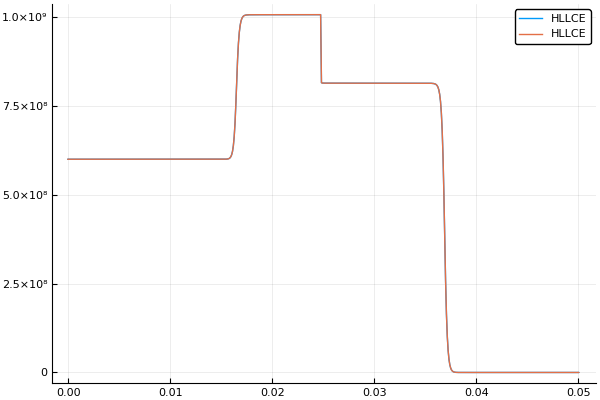

In [203]:
#using Plots
println(size(uo1))
pyplot()
#Plots.plot(xi,ui[:,3],label = "HLLCE",marker =  3,xlabel = "ρ (kg/m^3)")
Plots.plot!(x1,uo1[:,3],label = "HLLCE")

In [188]:
#using DelimitedFiles
f = open("400HLLCE.dat","w")
for i in 4:404
    print(f,x1[i]," ", uo1[i,1]," ",uo1[i,2]," ",uo1[i,3]," ",uo1[i,4], " ", -uo1[i,3]+uo1[i,4],"\n")
end
close(f)
#uu = read("4000x.txt",Float64)

In [181]:
#using DelimitedFiles
f = open("init.dat","w")
for i in 4:4004
    print(f,xi[i]," ", ui[i,1]," ",ui[i,2]," ",ui[i,3]," ",ui[i,4], " ", -ui[i,3]+ui[i,4],"\n")
end
close(f)
#uu = read("4000x.txt",Float64)

##### Pkg.add("DelimitedFiles")

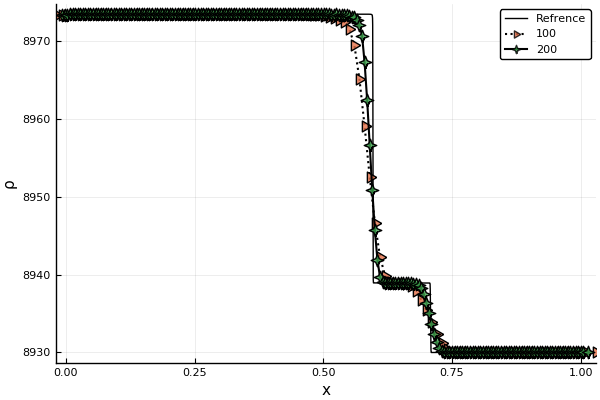

┌ Warning: Vectors of markers are currently unsupported in PyPlot: Symbol[:rtriangle]
└ @ Plots /home/bfly/.julia/packages/Plots/LWBTU/src/backends/pyplot.jl:200
┌ Warning: Vectors of markers are currently unsupported in PyPlot: Symbol[:star4]
└ @ Plots /home/bfly/.julia/packages/Plots/LWBTU/src/backends/pyplot.jl:200
┌ Warning: Vectors of markers are currently unsupported in PyPlot: Symbol[:rtriangle]
└ @ Plots /home/bfly/.julia/packages/Plots/LWBTU/src/backends/pyplot.jl:200
┌ Warning: Vectors of markers are currently unsupported in PyPlot: Symbol[:star4]
└ @ Plots /home/bfly/.julia/packages/Plots/LWBTU/src/backends/pyplot.jl:200


In [1308]:
pyplot()
plot(xexct,uoexct[:,1],xlims=[0.01,1],color =:black, label = "Refrence",xlabel = "x", ylabel = "ρ")
plot!(x100,uo100[:,1],marker = ([:rtriangle],9, 0.8 ), line =(:black,:dot, 1.5), label = "100")
plot!(x200,uo200[:,1],marker = ([:star4], 9, 0.8 ), line =(:black, 1.5), label = "200")
#plot!(x1002,uo1002[:,1])
#println(0.3960*1.4)

In [1273]:
for m  in Plots.supported_markers()
    println(m)
end

none
auto
circle
rect
star5
diamond
hexagon
cross
xcross
utriangle
dtriangle
rtriangle
ltriangle
pentagon
heptagon
octagon
star4
star6
star7
star8
vline
hline
+
x
pixel


In [1312]:
using DelimitedFiles
f = open("exact.dat","w")
writedlm(f,[xexct[4:end-4] uoexct[4:end-4,:]])
close(f)
f = open("200.dat","w")
writedlm(f,[x200[4:end-4] uo200[4:end-4,:]])
close(f)
f = open("100.dat","w")
writedlm(f,[x100[4:end-4] uo100[4:end-4,:]])
close(f)
f = open("400.dat","w")
writedlm(f,[x400[4:end-4] uo400[4:end-4,:]])
close(f)

In [1327]:
f = open("1002.dat","w")
writedlm(f,[x1002[4:end-4] uo1002[4:end-4,:]])
close(f)
f = open("100.dat","w")
writedlm(f,[x100[4:end-4] uo100[4:end-4,:]])
close(f)

In [1315]:
for i in 1:8000
    dx = 1/8000
    xexct[i] = i*dx
    if i*dx < 0.5965 
        uoexct[i,1] = 8973.453
        uoexct[i,2] = 20.0
        uoexct[i,3] = 681690362.286228418
        uoexct[i,4] = -6.0e7
    elseif i*dx < 0.70835
        uoexct[i,1] = 8938.93
        uoexct[i,2] = 4.7197
        uoexct[i,3] = 139127784.618057847
        uoexct[i,4] = -6.0e7
    else
        uoexct[i,1] = 8930.0
        uoexct[i,2] = 0.0
        uoexct[i,3] = 100000.0
        uoexct[i,4] = 0
    end
end
f = open("exact.dat","w")
writedlm(f,[xexct[4:end-4] uoexct[4:end-4,:]])
close(f)

In [1199]:
uo400 = uo1
x400 = x1

#51
err1 = zeros(Float64, (51,4))
for i in 0:50
    err1[i+1,4] = abs(uo2000[40*i+4,4]-uo50[i+4,4]) #/uo50[i+4,1]
end
println(maximum(err1)/maximum(uo50[:,4]) ,"********   ", sum(abs,err1)/51 /maximum(uo1[:,4]))

#101
err2 = zeros(Float64, (101,4))
for i in 0:100
    err2[i+1,4] = abs(uo2000[20*i+4,4]-uo100[i+4,4])#/uo100[i+4,4]
end
println(maximum(err2)/maximum(uo100[:,4]), "   ", sum(abs,err2)/101/maximum(uo100[:,4]))

#201
err3 = zeros(Float64, (201,4))
for i in 0:200
    err3[i+1,4] = abs(uo2000[10*i+4,4]-uo200[i+4,4])#/uo200[i+4,4]
end
println(maximum(err3)/maximum(uo200[:,4]) ,"   ", sum(abs,err3)/201/maximum(uo200[:,4]))

#401
err4 = zeros(Float64, (401,4))
for i in 0:400
    err4[i+1,4] = abs(uo2000[5*i+4,4]-uo400[i+4,4])  #/uo400[i+4,4]
end
println(maximum(err4)/maximum(uo400[:,4]) ,"   ", sum(abs,err4)/401/maximum(uo400[:,4]))

0.003550333174533279********   858.7016497621586
0.00036816413627934527   0.00010438910521782366
7.267158234096456e-5   1.4842978805673772e-5
1.4152396660204319e-5   2.387756943896677e-6


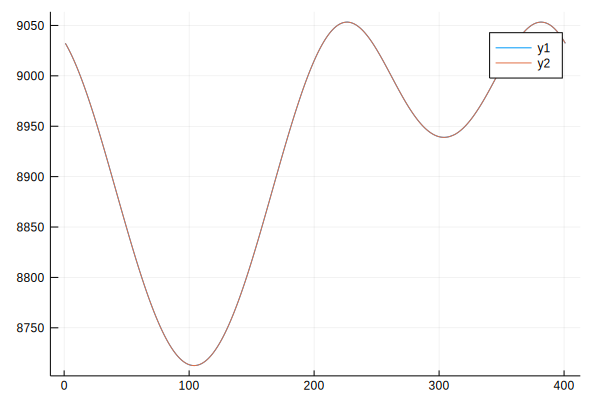

In [1120]:
plot(1:401, uo400[1:401,1])
plot!(1:401, uo4002[1:401,1])

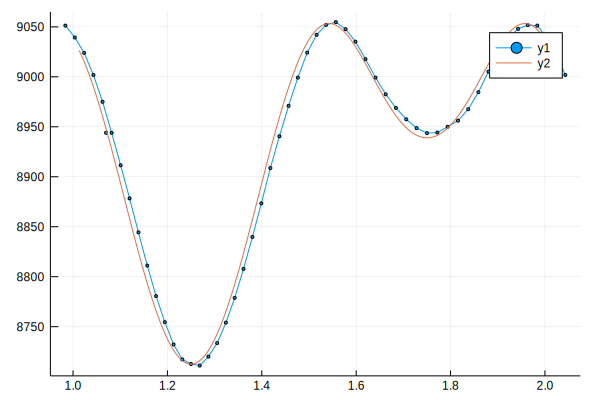

In [1090]:
plot(x50,uo50[:,1],marker =2)
plot!(x2000,uo2000[:,1])

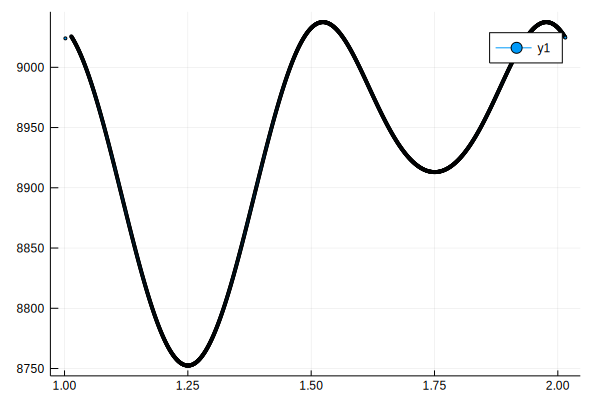

In [860]:
using Plots
#plot(x,uo[:,4],marker = 3)
#plot!(x,uo1[:,4],marker = 3)
plot(x2,uo2[:,1],marker=2)
#plot!(x3,uo3[:,4],marker = 2,)# xlims = (1.6,1.8), ylims = (8900,8950))
#plot!(x4,uo4[:,4],marker = 2,)#@ xlims = (1.6,1.8), ylims = (8900,8950))
#plot!(x1,uo1[:,4],marker = 2,) #xlims = (1.6,1.8), ylims = (8900,8950))
#plot!(x2,uo2[:,1],marker = 2,xlims = (0.032,0.038),ylims = (2980,3000))

In [817]:
x5 = copy(x1)
uo5 = copy(uo1)
size(uo4)

(107, 4)

In [791]:
using DelimitedFiles
f = open("2000x.txt","w")
writedlm(f,[x2 uo2])
close(f)
uu = readdlm("2000x.txt",Float64)

2007×5 Array{Float64,2}:
 NaN        9025.98  9812.92  1.00386e12  -5249.06
   1.0137   9025.66  9812.65  1.00414e12  -5416.47
   1.0142   9025.34  9812.39  1.00443e12  -5583.67
   1.01469  9025.02  9812.14  1.00471e12  -5750.66
   1.01519  9024.69  9811.88  1.00499e12  -5917.44
   1.01568  9024.36  9811.63  1.00527e12  -6084.01
   1.01618  9024.03  9811.38  1.00556e12  -6250.37
   1.01667  9023.69  9811.14  1.00584e12  -6416.51
   1.01716  9023.35  9810.9   1.00612e12  -6582.44
   1.01766  9023.0   9810.67  1.0064e12   -6748.15
   1.01815  9022.65  9810.43  1.00668e12  -6913.64
   1.01865  9022.29  9810.21  1.00695e12  -7078.92
   1.01914  9021.93  9809.98  1.00723e12  -7243.97
   ⋮                                              
   2.01073  9027.49  9814.3   1.00243e12  -4408.94
   2.01123  9027.2   9814.02  1.00272e12  -4577.37
   2.01172  9026.9   9813.74  1.003e12    -4745.6 
   2.01222  9026.6   9813.46  1.00329e12  -4913.62
   2.01271  9026.29  9813.19  1.00357e12  -5081.44
   2.0

(2007, 5)